In [12]:

import sys
import os

# Get the project root relative to the notebook location
# Assumes the notebook is inside 'notebooks/' one level below project root
project_root = os.path.abspath("..")  # go one folder up
if project_root not in sys.path:
    sys.path.append(project_root)

# Now you can import your modules

In [13]:
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from core import DataLoader, Profiler, Preprocessor, EDA, Visualizer

warnings.filterwarnings("ignore")
sns.set(style="whitegrid", rc={"figure.figsize": (10, 5)})

In [14]:
COUNTRY = "benin"
RAW_PATH = f"../data/raw/{COUNTRY}.csv"
CLEAN_PATH = f"../data/processed/{COUNTRY}_clean.csv"

print(f"Running EDA for: {COUNTRY.upper()}")

Running EDA for: BENIN


In [7]:
loader = DataLoader(base_path="../data/raw")
df = loader.load_csv(f"{COUNTRY}.csv")

print(f"✅ Loaded {len(df)} rows and {len(df.columns)} columns.")
df.head()

✅ Loaded 525600 rows and 19 columns.


,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
0,2021-08-09 00:01:00,-1.2,-0.2,-1.1,0.0,0.0,26.2,93.4,0.0,0.4,0.1,122.1,0.0,998,0,0.0,26.3,26.2,NaN
1,2021-08-09 00:02:00,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.6,0.0,0.0,0.0,0.0,0.0,998,0,0.0,26.3,26.2,NaN
2,2021-08-09 00:03:00,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.7,0.3,1.1,0.5,124.6,1.5,997,0,0.0,26.4,26.2,NaN
3,2021-08-09 00:04:00,-1.1,-0.1,-1.0,0.0,0.0,26.2,93.3,0.2,0.7,0.4,120.3,1.3,997,0,0.0,26.4,26.3,NaN
4,2021-08-09 00:05:00,-1.0,-0.1,-1.0,0.0,0.0,26.2,93.3,0.1,0.7,0.3,113.2,1.0,997,0,0.0,26.4,26.3,NaN


In [8]:
profiler = Profiler(df)

print("📊 Summary Statistics:")
display(profiler.summary())

print("\n📉 Missing Value Report:")
display(profiler.missing_report())

📊 Summary Statistics:


,count,mean,min,25%,50%,75%,max,std
Timestamp,525600,2022-02-07 12:00:30.000000512,2021-08-09 00:01:00,2021-11-08 06:00:45,2022-02-07 12:00:30,2022-05-09 18:00:15,2022-08-09 00:00:00,NaN
GHI,525600.0,240.559452,-12.9,-2.0,1.8,483.4,1413.0,331.131327
DNI,525600.0,167.187516,-7.8,-0.5,-0.1,314.2,952.3,261.710501
DHI,525600.0,115.358961,-12.6,-2.1,1.6,216.3,759.2,158.691074
ModA,525600.0,236.589496,0.0,0.0,4.5,463.7,1342.3,326.894859
ModB,525600.0,228.883576,0.0,0.0,4.3,447.9,1342.3,316.536515
Tamb,525600.0,28.179683,11.0,24.2,28.0,32.3,43.8,5.924297
RH,525600.0,54.487969,2.1,28.8,55.1,80.1,100.0,28.073069
WS,525600.0,2.121113,0.0,1.0,1.9,3.1,19.5,1.603466
WSgust,525600.0,2.809195,0.0,1.3,2.6,4.1,26.6,2.02912



📉 Missing Value Report:


,missing_count,missing_pct
Comments,525600,100.0


In [9]:
z_cols = ["GHI", "DNI", "DHI", "ModA", "ModB", "WS", "WSgust"]
z_cols = [c for c in z_cols if c in df.columns]

_, mask = profiler.detect_outliers(z_cols)
print(f"🚨 Detected {mask.sum()} outlier rows (|Z| > 3).")

🚨 Detected 7740 outlier rows (|Z| > 3).


In [10]:
cleaner = Preprocessor(df)

# Fill missing values with median
df_clean = cleaner.fill_missing(z_cols)

# Drop rows flagged as outliers
df_clean = cleaner.drop_outliers(mask)

print(f"✅ Cleaned dataset shape: {df_clean.shape}")

✅ Cleaned dataset shape: (517860, 19)


In [15]:
df_clean.to_csv(CLEAN_PATH, index=False)
print(f"💾 Cleaned data saved to: {CLEAN_PATH}")

💾 Cleaned data saved to: ../data/processed/benin_clean.csv


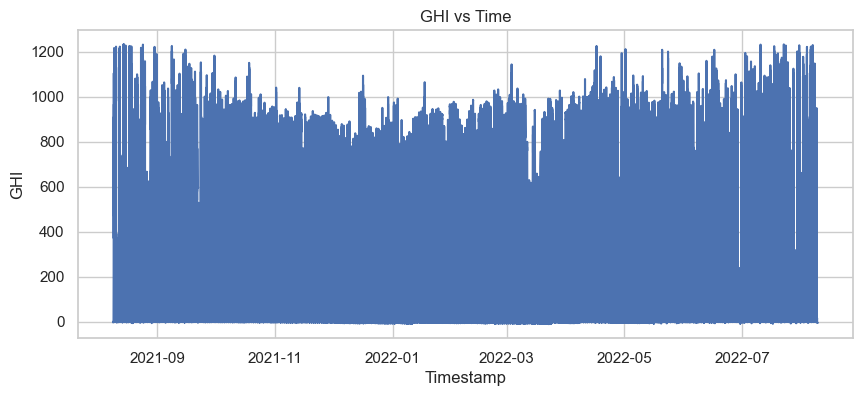

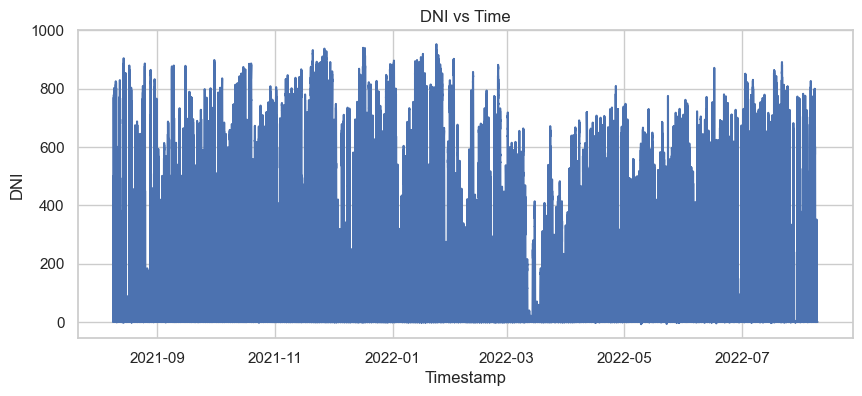

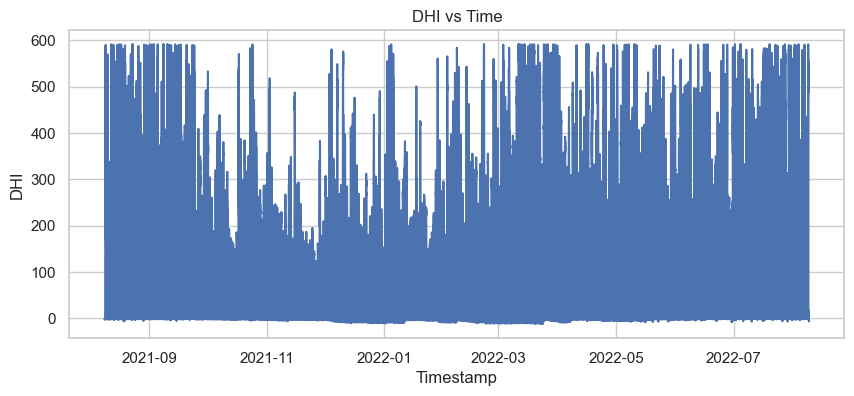

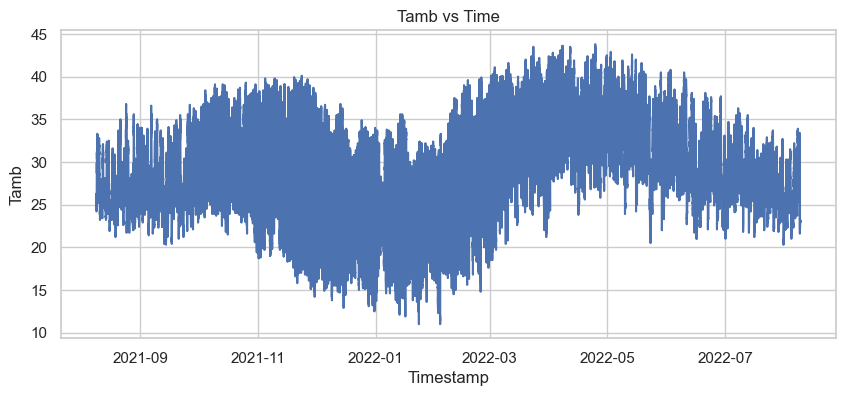

In [16]:
eda = EDA(df_clean)
eda.plot_time_series(["GHI", "DNI", "DHI", "Tamb"])

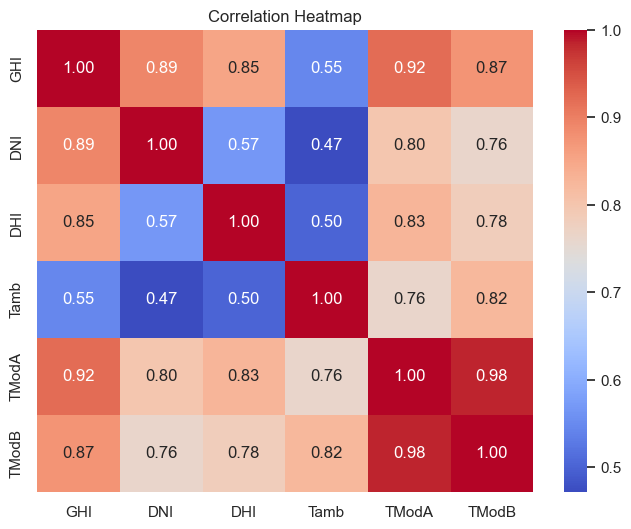

In [17]:
eda.correlation_heatmap(["GHI", "DNI", "DHI", "Tamb", "TModA", "TModB"])

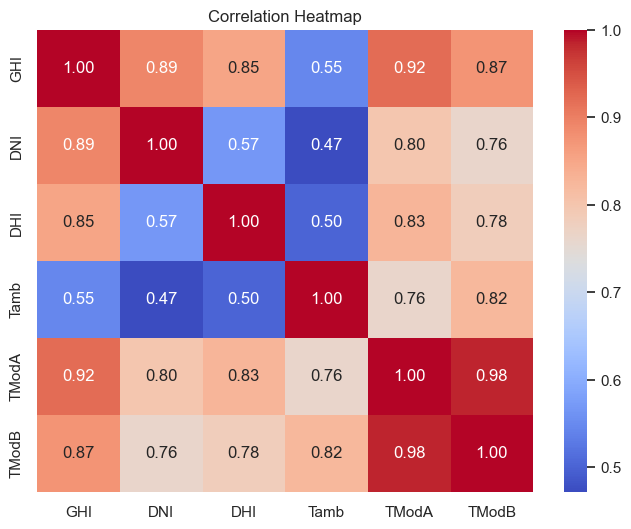

In [18]:
eda.correlation_heatmap(["GHI", "DNI", "DHI", "Tamb", "TModA", "TModB"])

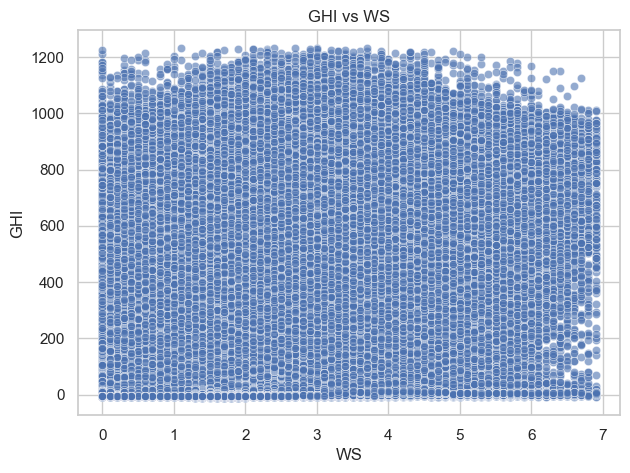

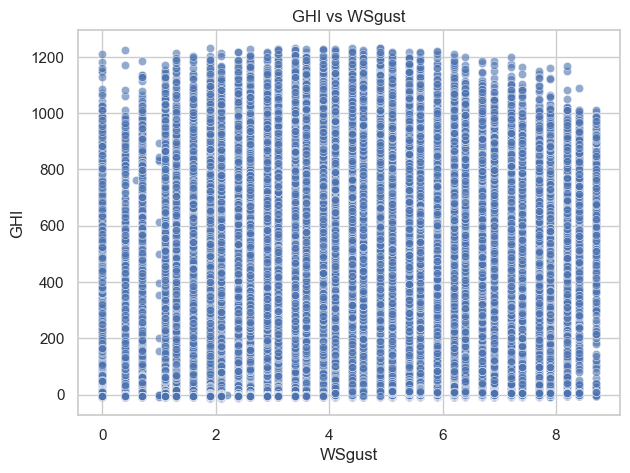

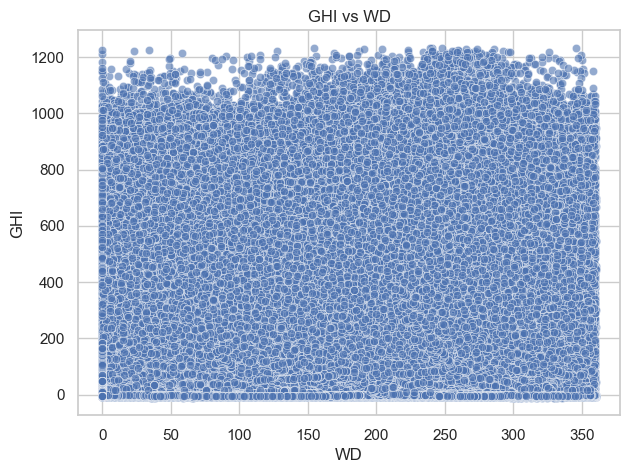

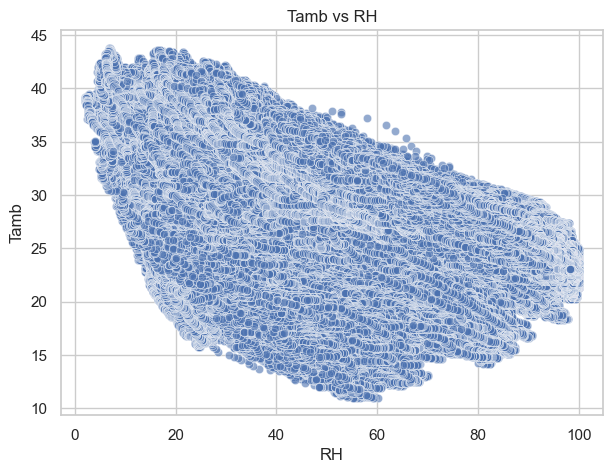

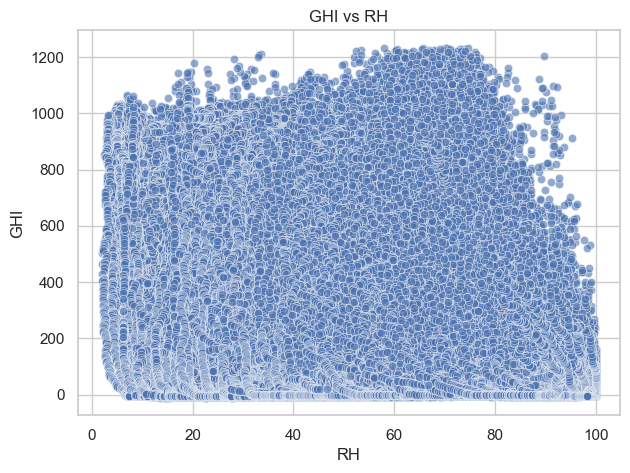

In [19]:
for col in ["WS", "WSgust", "WD"]:
    if col in df_clean.columns:
        eda.scatter(col, "GHI")

if "RH" in df_clean.columns:
    eda.scatter("RH", "Tamb")
    eda.scatter("RH", "GHI")

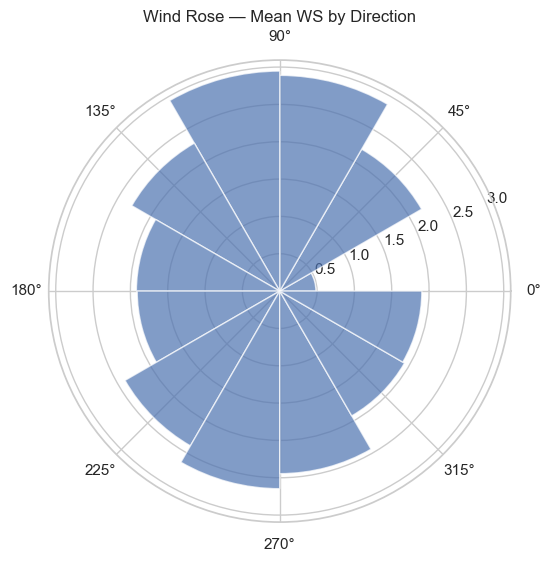

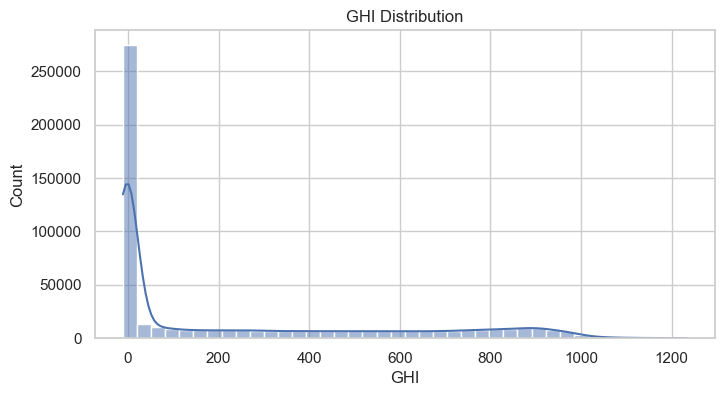

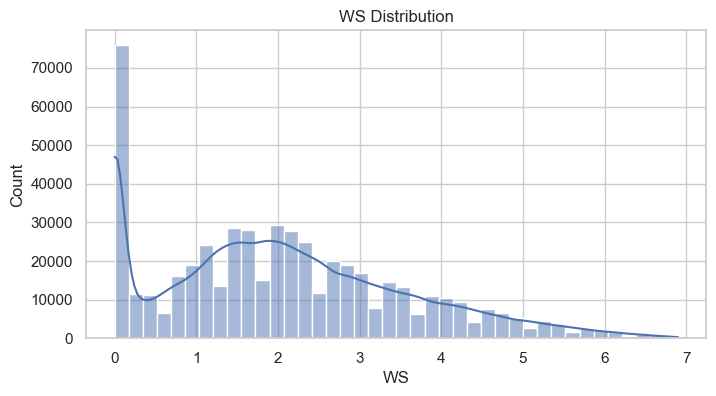

In [20]:
viz = Visualizer()

viz.wind_rose(df_clean)
viz.histograms(df_clean, ["GHI", "WS"])

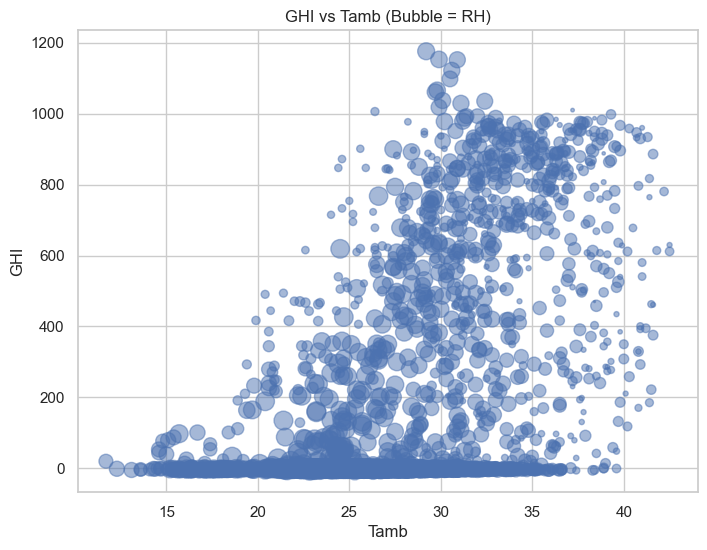

In [21]:
if all(col in df_clean.columns for col in ["Tamb", "GHI", "RH"]):
    viz.bubble_chart(df_clean, "Tamb", "GHI", "RH",
                     "GHI vs Tamb (Bubble = RH)")

In [22]:
# 🔍 Summary of Observations
# - Note any months, times of day, or locations with unusually high GHI/DNI/DHI.
# - Observe relationships between humidity, temperature, and solar radiation.
# - Summarize findings that could affect regional solar potential.
print("✅ EDA for Benin completed successfully.")

✅ EDA for Benin completed successfully.
